In [1]:
from SocialNetwork.social_network_environment import *
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from Advertising.learners.Greedy_algorithm import *
from Advertising.learners.UCB_no_anything import *
from Advertising.learners.UCB_no_qualities import *

seed = 6789 
arms = arms_creation(seed = 30291, number_of_arms= 20)
random.seed(seed)

exploration=4.2

deltas=[0.5,0.42,0.38,0.30,0.2,0.05]

social_network = social_network_environment()
social_network.init_from_json(json_path_network='Config/network.json', json_path_features='Config/features.json')


n_rounds=10000




In [2]:
from tqdm.notebook import tqdm_notebook

def create_adv_bids():
    
    adversary_bids = []
    for _ in range(0, 10): 
        adversary_i_bids = []
        for _ in range(0, 5):
            adversary_i_bids.append(random.randint(0, 4))
        adversary_bids.append(adversary_i_bids)
    return adversary_bids

def experiment(rounds, learner, all_bids, first = False, qualities = False):
    
    vcg = VCG()

    for t in tqdm_notebook(range(0, rounds)):

        index=learner.pull_arm()
        best_arm = arms[index]


        all_bids.insert(0, best_arm)
        ad_allocation_list = setup(bids=all_bids, n_bids=5)
        best_allocation = vcg.all_best_allocations(ad_allocation_list, social_network)

        if first:
            for j in range(0, len(best_allocation)):
                temp_allocation = []
                temp_allocation = best_allocation[j]
                for k in range(0, len(best_allocation[j])):
                    if temp_allocation[k].ad_id == 1 and k != 0:
                        temp_allocation[k].ad_id = None
                        best_allocation[j] = temp_allocation

        # Computing payments
        payments = vcg.payments(ad_allocation_list, best_allocation, social_network)

        if qualities:
            active_nodes, total_reward = active_nodes_click(social_network, best_allocation, deltas, learner_id=1)
        else:     
            active_nodes, total_reward = activate_cascade(social_network=social_network, ad_allocation_list=best_allocation, slot_prominence=deltas,learner_id=1)

        payments_tot = calculate_total_payment(payments, social_network.categories, active_nodes)


        reward = (total_reward-payments_tot)

        if qualities:
            learner.update(index, reward, np.where(active_nodes==1)[0])
        else:
            learner.update(index, reward)

        all_bids.pop(0)
        reset_nodes(social_network)

# Function for computing the rolling mean (i.e. moving average)
def compute_ma(collected_rewards):
    ma = []
    ma.append(0)

    for t in range(1,len(collected_rewards)):
        ma.append((ma[-1] * (t-1) +collected_rewards[t]) / t)
    
    return ma

def plot_clairvoyant(learner):
    collected_rewards = learner.collected_rewards
    rolling_mean = compute_ma(collected_rewards)
    best_arm = learner.return_best_arm()
    clairvoyant = learner.exp_values[best_arm]

    plt.figure()
    plt.axhline(y = clairvoyant, color = 'r', linestyle = '-')
    plt.plot(rolling_mean, color = 'b')
    plt.show()

all_bids = create_adv_bids()

In [3]:
from Advertising.learners.UCB_Learner import *
# Running UCB, without everything, samples only in first position

learner = UCB_Learner(arms = arms, hyperpar = exploration)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = True, qualities = False)

# Plotting
plot_clairvoyant(learner = learner)



TypeError: reset() missing 1 required positional argument: 'self'

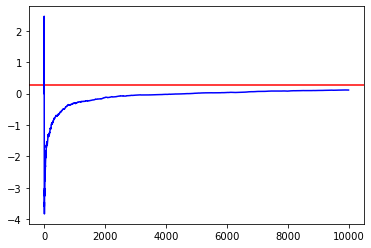

In [ ]:
from Advertising.learners.UCB_Learner_qualities import *

# Running UCB, missing qualities, samples in only first position

learner = UCB_Learner_qualities(arms = arms, hyperpar = exploration, social_network = social_network)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = True, qualities = True)

# Plotting
plot_clairvoyant(learner = learner)


In [ ]:
from Advertising.learners.UCB_Learner_qualities import *

# Running UCB, missing everything, all samples

learner = UCB_Learner(arms = arms, hyperpar = exploration, social_network = social_network)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = False, qualities = False)

# Plotting
plot_clairvoyant(learner = learner)


TypeError: update() missing 1 required positional argument: 'seeds'

In [ ]:
from Advertising.learners.UCB_Learner_qualities import *

# Running UCB, missing qualities, all samples

learner = UCB_Learner_qualities(arms = arms, hyperpar = exploration, social_network = social_network)

experiment(rounds = n_rounds, learner = learner, all_bids = all_bids, first = False, qualities = True)

# Plotting
plot_clairvoyant(learner = learner)
